# Adaptive averaging

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import norm

%matplotlib widget

## Settings

In [2]:
confint_percentage = 0.95
confint_stddev_low, confint_stddev_high = norm.interval(confint_percentage)

confint_percentage_half = (1 - confint_percentage) / 2
confint_percentile_low = confint_percentage_half
confint_percentile_high = 1 - confint_percentage_half

## Averaging algorithm

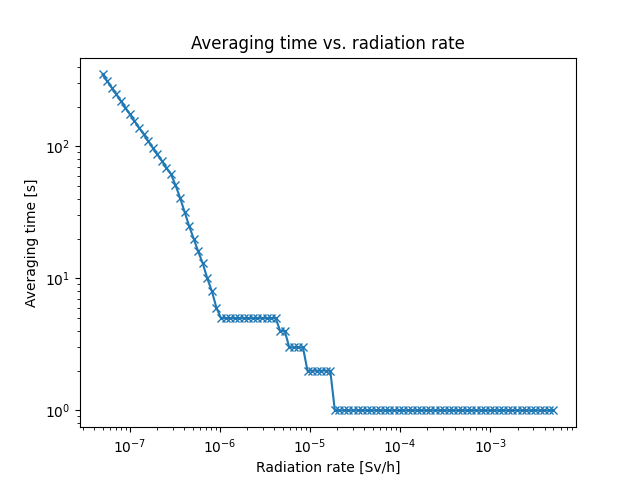

In [3]:
averaging_time_constant = 20
averaging_period_time_min = 5
averaging_period_time_max = 300
averaging_transition_svh_min = 0.3E-6
averaging_transition_svh_max = 1.0E-6

sv_h_min = 0.05E-6

#conversion_factor = 153.8   # M4011
conversion_factor = 68.4    # J614

cps_to_svh = 60 * 1E-6 / conversion_factor

svh = sv_h_min * np.logspace(0, 5, 100)
cps = svh / cps_to_svh

avg_time = []
for svh_value in svh:
    cps_value = svh_value / cps_to_svh

    if svh_value > averaging_transition_svh_min and svh_value < averaging_transition_svh_max:
        averaging_transition_cps_min = (averaging_transition_svh_min / cps_to_svh)
        averaging_transition_time_min = (averaging_time_constant / averaging_transition_cps_min)
        averaging_transition_time_max = averaging_period_time_min

        transition_base = (svh_value / averaging_transition_svh_max)
        transition_exponent = np.log(averaging_transition_time_min / averaging_transition_time_max) /\
            np.log(averaging_transition_svh_min / averaging_transition_svh_max)
        avg_time_value = averaging_transition_time_max * (transition_base ** transition_exponent)

    else:
        avg_time_value = averaging_time_constant / cps_value

        if svh_value >= averaging_transition_svh_max:
            if avg_time_value > averaging_period_time_min:
                avg_time_value = averaging_period_time_min

    avg_time_value = np.ceil(avg_time_value)

    avg_time.append(avg_time_value)

plt.figure()
plt.title('Averaging time vs. radiation rate')
plt.xlabel('Radiation rate [Sv/h]')
plt.ylabel('Averaging time [s]')
plt.loglog(svh, avg_time, marker='x')
plt.show()

## Resulting confidence intervals

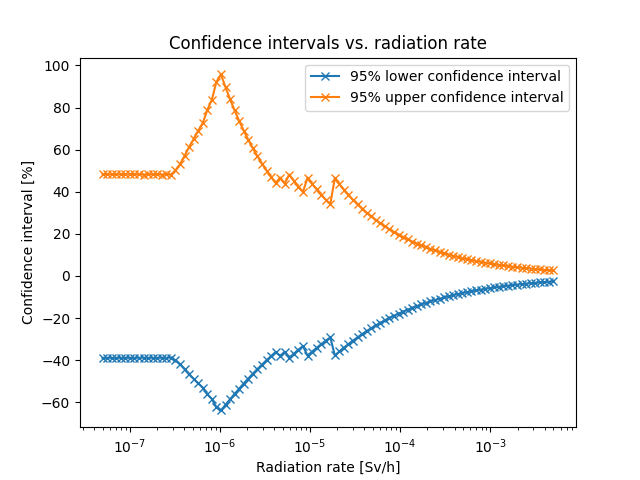

In [4]:
n = cps * avg_time

n_low = 0.5 * chi2.ppf(confint_percentile_low, df=2 * n)
n_high = 0.5 * chi2.ppf(confint_percentile_high, df=2 * n)

confint_low = (n_low - n) / n
confint_high = (n_high - n) / n

plt.figure()
plt.title('Confidence intervals vs. radiation rate')
plt.xlabel('Radiation rate [Sv/h]')
plt.ylabel('Confidence interval [%]')
c1, = plt.semilogx(svh, 100 * confint_low, marker='x', label='95% lower confidence interval')
c2, = plt.semilogx(svh, 100 * confint_high, marker='x', label='95% upper confidence interval')
plt.legend(handles=[c1, c2], loc='upper right')
plt.show()